# Synthesize search sessions from signals

This notebook synthesizes search sessions from the CTR of the clicked documents on each search result. It's assumed that if you order results by CTR, that roughly captures the source search system's relevance ranking in aggregate (including all the position and other biases). 

You can then check to see if the document is above or below average for that rank position (using a z score). You can then use that z score to translate that document to any other position. 

This is intended more for creating fake search session data for examples in AI Powered Search, and not a replacement for actually logging real search sessions in your search system.

In [278]:
! cd ../data/retrotech && head signals.csv

import random
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from aips import *
import os
from IPython.core.display import display,HTML

signals = pd.read_csv('../data/retrotech/signals.csv')

#seed=8675309
#random.seed(seed)
#np.random.seed(seed)

DOCS_PER_SESSION=20 # how many docs in one search page view?
NUM_SESSIONS=5000 # how many sessions to generate for each query?

# Generate search sessions for these queries
QUERIES_TO_SIMULATE=['dryer', 'iphone', 'nook', 'kindle', 
                     'lcd tv', 'ipad', 'headphones', 'macbook',
                     'how i met your mother', 'star wars', 'star trek',
                     'blue ray', 'bluray']

"query_id","user","type","target","signal_time"
"u2_0_1","u2","query","nook","2019-07-31 08:49:07.3116"
"u2_1_2","u2","query","rca","2020-05-04 08:28:21.1848"
"u3_0_1","u3","query","macbook","2019-12-22 00:07:07.0152"
"u4_0_1","u4","query","Tv antenna","2019-08-22 23:45:54.1030"
"u5_0_1","u5","query","AC power cord","2019-10-20 08:27:00.1600"
"u6_0_1","u6","query","Watch The Throne","2019-09-18 11:59:53.7470"
"u7_0_1","u7","query","Camcorder","2020-02-25 13:02:29.3089"
"u9_0_1","u9","query","wireless headphones","2020-04-26 04:26:09.7198"
"u10_0_1","u10","query","Xbox","2019-09-13 16:26:12.0132"


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Gather queries occuring above a certain threshold

In [279]:
MIN_QUERY_EVENTS=100

queries = signals[signals['type'] == 'query']
popular_queries = queries.groupby('target').count() \
                         .rename(columns={'query_id': 'query_count'}) \
                         .sort_values('query_count', ascending=False)
popular_queries = popular_queries[popular_queries['query_count'] > MIN_QUERY_EVENTS].index.to_list()
pop_query_events = signals[signals['type'] == 'query'][signals['target'].isin(popular_queries)]
query_events = pop_query_events[['query_id', 'target']].rename(columns={'target': 'query'})

# Cleanup by lowercasing
# This step has its pros and cons. We might miss some info that case gives us, but it also
# aggregates more signal per query
query_events['query'] = query_events['query'].apply(lambda q: q.lower())
query_event_counts = query_events.groupby('query')['query_id'].count().reset_index().sort_values('query_id', ascending=False)
query_event_counts[query_event_counts['query'].str.contains('blue ray')]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,query,query_id
104,blue ray,276


# Join click events with corresponding queries into one table

In [280]:
clicks = signals[signals['type'] == 'click']
click_events = clicks[['query_id', 'target']].rename(columns={'target': 'clicked_doc_id'})
clicks_per_query = query_events.merge(click_events, 
                                      on='query_id', 
                                      how='left')
clicks_per_query['clicked_doc_id'] = clicks_per_query['clicked_doc_id'].fillna(0)
# clicks_per_query.groupby('query').count().sort_values('query_id', ascending=False)

clicks_per_query

,query_id,query,clicked_doc_id
0,u2_0_1,nook,9781400532650
1,u2_1_2,rca,883393001119
2,u3_0_1,macbook,885909464036
3,u4_0_1,tv antenna,079000334835
4,u7_0_1,camcorder,027242821866
...,...,...,...
488539,u744327_0_1,dre beats,848447000135
488540,u744328_0_1,sirius radio,884720004032
488541,u744330_0_1,usb drive,718037770604
488542,u744331_0_1,iphone 4s,885909538027


# Compute a CTR for each query/doc pair

0.15889705213356384
0.10964912280701754
0.07842453816660858
0.059931506849315065


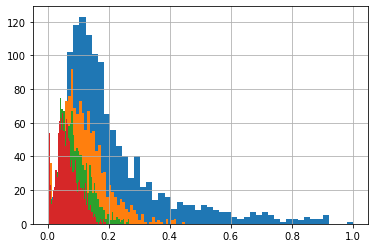

In [281]:
# tot number of queries (denom if CTR)
denominator = query_events.groupby('query').count().rename(columns={'query_id': 'tot_query_count'})

# click counts per doc in query
click_thru_rate = clicks_per_query.groupby(['query', 'clicked_doc_id']).count().rename(columns={'query_id':'click_count'}).reset_index()
click_thru_rate = click_thru_rate.merge(denominator, on='query', how='left')

click_thru_rate['ctr'] = click_thru_rate['click_count'] / click_thru_rate['tot_query_count']
click_thru_rate = click_thru_rate.sort_values(['query', 'ctr'], ascending=[True, False])

# Get rid of doc_id 0, which is all the queries with no clicks
# We treat these as a canonical ranking from the source system, assume it's relatively
# highly tuned and the source CTRs are pretty reasonably close to actual relevance ranking
# in the source system. Of course this is a dubious assumption in a real search system, 
# but for our purposes - to synthesize reasonable looking search sessions - it will serve
canonical_rankings = click_thru_rate[click_thru_rate['clicked_doc_id'] != 0].reset_index()


# Just for display and sanity checking
print(canonical_rankings.groupby('query').nth(0)['ctr'].median())
canonical_rankings.groupby('query').nth(0)['ctr'].hist(bins=50)

print(canonical_rankings.groupby('query').nth(1)['ctr'].median())
canonical_rankings.groupby('query').nth(1)['ctr'].hist(bins=50)

print(canonical_rankings.groupby('query').nth(2)['ctr'].median())
canonical_rankings.groupby('query').nth(2)['ctr'].hist(bins=50)

print(canonical_rankings.groupby('query').nth(3)['ctr'].median())
canonical_rankings.groupby('query').nth(3)['ctr'].hist(bins=50)

# Compute stats of each CTR position

What's the mean, median, std deviaton, etc of CTR in each position? This lets us synthesize sessions assuming the above average or below average CTR is an indication of above or below average relevance

In [282]:
canonical_rankings['rank'] = canonical_rankings.groupby('query').cumcount()

# Idea
# Compute neg z scores for items below mean and positive z scores for items above mean
# but negative z scores are fit to a distribution of only the negative values and the negative values + mean
# similarly for positive values

max_depth = canonical_rankings['rank'].max()
for i in range(0, max_depth):
    idxs = canonical_rankings[canonical_rankings['rank'] == i].index
   
    # Mean based statistics
    canonical_rankings.loc[idxs, 'posn_ctr_mean'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].mean()
    canonical_rankings.loc[idxs, 'posn_ctr_std'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].std()
 
    # Median based statistics (less outlier prone)
    canonical_rankings.loc[idxs, 'posn_ctr_median'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].median()
    canonical_rankings.loc[idxs, 'posn_ctr_mad'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].mad()

canonical_rankings['ctr_std_z_score'] = (canonical_rankings['ctr'] - canonical_rankings['posn_ctr_mean']) / canonical_rankings['posn_ctr_std']
canonical_rankings['ctr_mod_z_score'] = (canonical_rankings['ctr'] - canonical_rankings['posn_ctr_median']) / canonical_rankings['posn_ctr_mad']

canonical_rankings[canonical_rankings['query'] == 'dryer'].head(20)

,index,query,clicked_doc_id,click_count,tot_query_count,ctr,rank,posn_ctr_mean,posn_ctr_std,posn_ctr_median,posn_ctr_mad,ctr_std_z_score,ctr_mod_z_score
15580,15844,dryer,12505451713,20,246,0.081301,0,0.215521,0.172469,0.158897,0.124872,-0.778227,-0.621404
15581,15893,dryer,883929085118,18,246,0.073171,1,0.121488,0.070496,0.109649,0.054231,-0.685393,-0.672647
15582,15887,dryer,883049066905,16,246,0.065041,2,0.087093,0.048757,0.078425,0.038821,-0.452290,-0.344763
15583,15854,dryer,36172950027,13,246,0.052846,3,0.065306,0.036182,0.059932,0.028924,-0.344385,-0.244987
15584,15870,dryer,74108056764,13,246,0.052846,4,0.051849,0.030129,0.048343,0.024117,0.033090,0.186711
15585,15872,dryer,77283045400,13,246,0.052846,5,0.041020,0.024764,0.039578,0.019993,0.477524,0.663618
15586,15883,dryer,783722274422,13,246,0.052846,6,0.031860,0.019346,0.031660,0.015932,1.084741,1.329765
15587,15880,dryer,665331101927,11,246,0.044715,7,0.026049,0.016632,0.025751,0.013968,1.122345,1.357717
15588,15848,dryer,14381196320,9,246,0.036585,8,0.021772,0.014593,0.020859,0.012446,1.015130,1.263529
15589,15871,dryer,74108096487,9,246,0.036585,9,0.018520,0.012575,0.017204,0.010934,1.436546,1.772473


# Create a single search session

Given statistics on CTR, assume the search engine returns a shuffled list of results, and recompute likely CTR for each position. Then randomly select whether there was a click

In [283]:
def synthesize_session(query, sess_id):
    canonical = canonical_rankings[canonical_rankings['query'] == query]
    shuffled = canonical[['posn_ctr_mean', 'posn_ctr_std', 'rank']]\
        .rename(columns={'rank': 'dest_rank'})
    shuffled = shuffled[shuffled['dest_rank'] < DOCS_PER_SESSION]\
        .sample(frac=1)\
        .rename(columns={'posn_ctr_std': 'dest_ctr_std',
                         'posn_ctr_mean': 'dest_ctr_mean'})
    shuffled = shuffled.reset_index(drop=True).reset_index().rename(columns={'index': 'rank'})
    shuffled = shuffled.merge(canonical, on='rank', how='left')
    # shuffled['dest_ctr_1'] = (shuffled['ctr_mod_z_score'] * shuffled['dest_ctr_median']) / (shuffled['dest_ctr_mad'])
    shuffled['dest_ctr'] = (shuffled['ctr_std_z_score'] * shuffled['dest_ctr_std']) + (shuffled['dest_ctr_mean'])
    shuffled['draw'] = np.random.rand(len(shuffled))
    shuffled['clicked'] = shuffled['draw'] < shuffled['dest_ctr']
    shuffled['sess_id'] = sess_id

    return shuffled

# Randomly sample source signals, generate new sessions

In [319]:
from time import perf_counter 
sess_id = 0

for query in QUERIES_TO_SIMULATE:
    
    session_dfs=[]
    t1_start = perf_counter()  
    if len(canonical_rankings[canonical_rankings['query'] == query]) > 0:
        for i in range(0, NUM_SESSIONS):
            session_dfs.append(synthesize_session(query, sess_id))
            sess_id+=1
            if (sess_id % 500 == 0):
                print("Created Sessions %s Last Query %s Elapsed %s" % (sess_id, query, perf_counter()-t1_start))
    else:
        print("Query %s not available" % query)

    sessions = pd.concat(session_dfs)
    sessions = sessions.sort_values(['sess_id', 'dest_rank'])
    sessions[['sess_id', 'query', 'dest_rank', 'clicked_doc_id', 'clicked']] \
        .rename(columns={'dest_rank': 'rank'}) \
        .to_csv("%s_sessions.gz" % query, compression='gzip', index=False)

Created Sessions 500 Last Query dryer Elapsed 8.376421799999662
Created Sessions 1000 Last Query dryer Elapsed 16.616907600022387
Created Sessions 1500 Last Query dryer Elapsed 24.93830690003233
Created Sessions 2000 Last Query dryer Elapsed 33.489036199986
Created Sessions 2500 Last Query dryer Elapsed 41.713171700015664
Created Sessions 3000 Last Query dryer Elapsed 49.95659160002833
Created Sessions 3500 Last Query dryer Elapsed 58.15742489998229
Created Sessions 4000 Last Query dryer Elapsed 66.577935600013
Created Sessions 4500 Last Query dryer Elapsed 74.8301555000362
Created Sessions 5000 Last Query dryer Elapsed 82.97873030003393
Created Sessions 5500 Last Query iphone Elapsed 8.52991749998182
Created Sessions 6000 Last Query iphone Elapsed 17.032767300028354
Created Sessions 6500 Last Query iphone Elapsed 25.67759350000415
Created Sessions 7000 Last Query iphone Elapsed 34.197792100021616
Created Sessions 7500 Last Query iphone Elapsed 42.83109970000805
Created Sessions 8000 L

Created Sessions 60000 Last Query blue ray Elapsed 83.82040510000661
Created Sessions 60500 Last Query bluray Elapsed 8.552982599998359
Created Sessions 61000 Last Query bluray Elapsed 17.156356999999844
Created Sessions 61500 Last Query bluray Elapsed 25.38701319997199
Created Sessions 62000 Last Query bluray Elapsed 33.79575929994462
Created Sessions 62500 Last Query bluray Elapsed 42.19164669996826
Created Sessions 63000 Last Query bluray Elapsed 50.80415789998369
Created Sessions 63500 Last Query bluray Elapsed 59.225695099972654
Created Sessions 64000 Last Query bluray Elapsed 67.57441059994744
Created Sessions 64500 Last Query bluray Elapsed 76.21276159997797
Created Sessions 65000 Last Query bluray Elapsed 84.59616689995164


In [320]:
def all_sessions():
    import glob
    return pd.concat([pd.read_csv(f, compression='gzip')
                      for f in glob.glob('*_sessions.gz')])

sessions = all_sessions()
sessions

,sess_id,query,rank,clicked_doc_id,clicked
0,0,dryer,0,84691226727,True
1,0,dryer,1,12505525766,False
2,0,dryer,2,36725578241,True
3,0,dryer,3,12505527456,False
4,0,dryer,4,74108096487,False
...,...,...,...,...,...
99995,59999,blue ray,15,883929140855,False
99996,59999,blue ray,16,786936817232,False
99997,59999,blue ray,17,600603141003,False
99998,59999,blue ray,18,36725608511,False


In [321]:
def fetch_products(doc_ids):
    import requests
    doc_ids = ["%s" % doc_id for doc_id in doc_ids]
    query = "upc:( " + " OR ".join(doc_ids) + " )"
    params = {'q':  query, 'wt': 'json', 'rows': len(doc_ids)}
    resp = requests.get('http://aips-solr:8983/solr/products/select', params=params)
    df = pd.DataFrame(resp.json()['response']['docs'])
    df['upc'] = df['upc'].astype('int64')
    return df

products = fetch_products(doc_ids=sessions['clicked_doc_id'].unique())
products

,upc,name,manufacturer,shortDescription,longDescription,id,_version_
0,883393003458,"RCA - 46"" Class - LCD - 1080p - 60Hz - HDTV",RCA,\N,This HDTV showcases stunning images up to 1080...,953d1c22-88d7-4009-a5f6-b0783a411a11,1684550854019907593
1,843404064434,ZAGG - InvisibleSHIELD for Apple&#xAE; iPhone&...,ZAGG,Compatible with Apple&#xAE; iPhone&#xAE; 4; mi...,Protect your Apple iPhone 4's screen with this...,8355f53e-da62-4667-a86e-9fca0f927ad4,1684550854146785281
2,600603135101,Rocketfish&#x2122; - Protective Cover for NOOK,Rocketfish&#x99;,Compatible with NOOK WiFi and NOOK 3G+WiFi; th...,Protect your NOOK eReader from bumps and scrat...,7346a389-ef33-448e-b7e8-45208226d43b,1684550854148882432
3,813774010904,Samsung - Refurbished Wi-Fi Ready Blu-ray Pla...,Samsung,RefurbishedENERGY STAR QualifiedPlays DVD and ...,See movies come to life in brilliant high-defi...,fc81cd8c-376f-4f66-b4a2-59101009587f,1684550854156222466
4,97278016000,Furuno 600l Color LCD Fishfinder - DVD,\N,\N,\N,db3c0349-594f-4e89-85e3-8ceef1dc0494,1684550854261080072
...,...,...,...,...,...,...,...
218,30206696622,Star Trek [Music from the Motion Picture] - Or...,Var&#xBF;se Sarabande (USA),\N,\N,572370c6-9cde-4052-9cf0-e7ba144cef05,1684550854608158729
219,30206696622,Star Trek (Score) - Original Soundtrack - CD,Var&#xBF;se Sarabande (USA),\N,\N,1340079b-9d51-4664-862b-f33417f03742,1684550855913635852
220,786936817232,Pirates Of The Caribbean: On Stranger Tides (2...,\N,\N,\N,fc0243b3-74aa-4625-aea3-8f62374046e8,1684550857360670725
221,24543742180,Star Wars: The Complete Saga [9 Discs / Blu-ra...,\N,\N,\N,83071377-bcd3-44c3-a990-55aafeea01a2,1684550857673146372


In [322]:
#dryer_sessions = dryer_sessions.merge(dryer_products, left_on='clicked_doc_id', right_on='upc', how='left')
dryer_sessions=sessions[sessions['query'] == 'star trek']

num_sessions = len(dryer_sessions['sess_id'].unique())
dryer_ctrs = dryer_sessions.groupby('clicked_doc_id')['clicked'].sum().reset_index()
dryer_ctrs['ctr'] = dryer_ctrs['clicked'] / num_sessions
dryer_ctrs = dryer_ctrs.sort_values('clicked', ascending=False)\
                       .merge(products, left_on='clicked_doc_id', right_on='upc', how='left')
#dryer_sessions.groupby('clicked_doc_id').sum().sort_values('clicked', ascending=False)

dryer_ctrs

,clicked_doc_id,clicked,ctr,upc,name,manufacturer,shortDescription,longDescription,id,_version_
0,97361427546,369.0,0.0738,97361427546,Star Trek: The Original Motion Picture Collect...,\N,\N,\N,13762742-d2b5-42a4-8d15-e28db6ab099a,1684550857221210125
1,97360719642,327.0,0.0654,97360719642,Star Trek: Original Motion Picture Collection ...,\N,\N,\N,9dc2f05f-357a-4d2d-a69d-8cdcb77254de,1684550856419049483
2,13964123296,311.0,0.0622,13964123296,Keyscaper - <i>Star Trek: The Original Series<...,Keyscaper,Compatible with PC and Mac; wireless USB conne...,This keyboard features a wireless design for o...,0430371a-1c5e-486e-b771-425b84f06a42,1684550857309290506
3,30206696622,287.0,0.0574,30206696622,Star Trek [Music from the Motion Picture] - Or...,Var&#xBF;se Sarabande (USA),\N,\N,572370c6-9cde-4052-9cf0-e7ba144cef05,1684550854608158729
4,30206696622,287.0,0.0574,30206696622,Star Trek (Score) - Original Soundtrack - CD,Var&#xBF;se Sarabande (USA),\N,\N,1340079b-9d51-4664-862b-f33417f03742,1684550855913635852
5,97360719840,263.0,0.0526,97360719840,Star Trek: The Next Generation Motion Picture ...,\N,\N,\N,93fa6b02-d48b-43fe-9353-80cf51a12aba,1684550856419049476
6,97363485049,257.0,0.0514,97363485049,Star Trek - Widescreen Dubbed Subtitle AC3 - DVD,\N,\N,\N,d303a7fc-0ee8-4b08-8743-b64e520a7d6d,1684550856416952328
7,738572128920,252.0,0.0504,738572128920,Music Of Star Trek - O.S.T. - CD,Silva America,\N,\N,701565a5-12e3-44a6-9f0b-ee3ac0aa5b0f,1684550856397029396
8,97360719741,230.0,0.0460,97360719741,STAR TREK: THE NEXT GENERATION MOTION PICTURE ...,\N,\N,\N,a3c3f4a4-995c-45db-8932-940cb0b2bfe9,1684550856420098048
9,97361166247,200.0,0.0400,97361166247,Star Trek - Widescreen Dubbed Subtitle AC3 - B...,\N,\N,\N,dcf99f12-83c2-4eff-82cc-443ec39ae815,1684550855383056384


In [316]:
num_sessions = len(sessions['sess_id'].unique())
sessions.groupby('rank')['clicked'].sum() / num_sessions

rank
0     2.6236
1     1.5124
2     1.0868
3     0.7770
4     0.6486
5     0.5000
6     0.4074
7     0.3210
8     0.2680
9     0.2320
10    0.1858
11    0.1748
12    0.1402
13    0.1278
14    0.1180
15    0.1052
16    0.0982
17    0.0954
18    0.0860
19    0.0794
Name: clicked, dtype: float64

In [317]:
num_sessions

5000